# Welcome to interactive INTRO to Fourier Transform (FT) (TODO: code cleaning, comments)
  * I will not go deep into math in any way
  * But I will try to provide motivation, why FT is such a strong concept
  
1. Any decent function can be approximated by a fourier series, sum of sines and cosines.
2. It is especially useful for oscillatory signals.
3. Yes, the problem is the series is infinite.
3. However, if you get the fourier series, the terms are ordered by descending significance. This means you are always taking the most important terms first.
4. The rest of the terms are corrections to what you already have.
5. Crucial is that I have oscillatory function in time, and I am able to extract frequencies (lots of simple sine waves added to each other), which completely reconstruct my crazy looking oscillations in time.

In [20]:
# scientific modules
import numpy as np
from scipy import signal, fft

# imports for interactive plots
from dash import Dash, html, dcc, Input, Output
from jupyter_dash import JupyterDash
import plotly.express as px
import plotly.graph_objects as go

# standard plotting
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams['figure.facecolor'] = 'white'

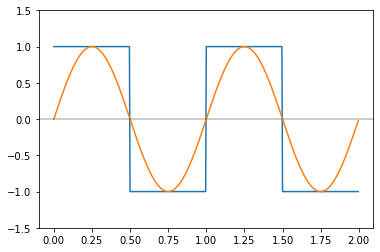

In [4]:
# create a squared function
t = np.linspace(0, 2, 500, endpoint=False)
plt.plot(t, signal.square(2 * np.pi * t))
plt.plot(t, np.sin(2*np.pi*t))
plt.axhline(0, color='k', lw=0.4)
plt.ylim(-1.5, 1.5)
plt.show()

Square function is very far from sine right. 

It oscillates, which is good, but how on Earth can you produce the sharp edge just using sines and cosines?

---

At University, this is fairly easy calculation on paper, however we take just the result from wikipedia (if you want to see more details check this [Wolfram explanation](https://mathworld.wolfram.com/FourierSeriesSquareWave.html)

\begin{align}
F(t)=\dfrac{4}{\pi}\sum_{k=1}^{\infty}{\dfrac{\sin{(2\pi(2k-1)ft)}}{2k-1}} = \dfrac{4}{\pi}\left(\sin{(\omega t)} + \dfrac{1}{3}\sin{(3\omega t)} + \dfrac{1}{5}\sin{(5\omega t)} + ...\right)
\end{align}
, for $\omega=2\pi ft$

In [34]:
## fourier series
def ft_series_square(x_axis, freq, n_harmonics):
    # first create array of zeros, where I am going to add the sin terms
    f_values = np.zeros(len(x_axis))
    # k is the k from the formula above
    for k in range(1, n_harmonics):
        # for higher and higher frequencies, adding the sin term to my existing values
        f_values = f_values + np.sin(2*np.pi*(2*k-1)*freq*x_axis)/(2*k-1) 
    return f_values*4/np.pi  # multiplying only once the whole thing, insted of n_harmonics-times (in each iteration) 

## FFT stands for fast fourier transform, it is standard and very fast algorithm to calculate FT
def do_fft(x, f):
    t_step = abs(x[1] - x[0])
    f_fft = fft.fft(f)
    x_fft = fft.fftfreq(len(x), t_step)[:len(x)//2]
    return x_fft, 2.0/len(x) * np.abs(f_fft[0:len(x)//2])

## The following part is the interactive plotting definitions
  * It looks a bit complicated, but this sort of knowledge can get you actually hired one day. Because:
  * These plots run on the web, so it nicely integrates any kind of webpage.
  * You might notice that dash makes interface to html, so you create html page using python style of coding.
  * And you can share it easily with the world.
  * Read my comments if you are interested. If not, we are calculating the same as above. Generating the FT series for the left graph and doing FT of it in the second one.

In [31]:
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1('How FFT works.'),
    
    html.Div([
        html.Div([
            dcc.Graph(id='time_domain_lines')
        ], style={'width':'49%', 'display': 'inline-block'}),
    html.Div([
        dcc.Graph(id='fft_lines')
    ], style={'width': '49%', 'display': 'inline-block'}),
    
    html.H3('Number of harmonics'),
    html.Div(dcc.Slider(
        1, 20, step=1,
        id='n_harmonics_slider',
        value=2
    ), style={'width': '100%', 'display': 'inline-block'}),
], style={'width': '100%', 'display': 'inline-block'}),
    
    
], style={'backgroundColor':'white'})

@app.callback(
    Output('time_domain_lines', 'figure'),
    Input('n_harmonics_slider', 'value'))

def update_graph(n_harmonics_value):
    t = np.linspace(0, 2, 500, endpoint=False)
    f = ft_series_square(t, 1, n_harmonics_value)
    fig = go.Figure()
    fig.add_trace(go.Line(x=t, y=f, name='FT sine series'))
    
    fig.add_trace(go.Line(x=t, y=signal.square(2 * np.pi * t), name='Square wave'))
    fig.update_layout(yaxis_range=[-1.5,1.5])
    fig.update_layout(legend=dict(
        yanchor="top",
        y=1.2,
        xanchor="left",
        x=0.01
        ))
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        )
    return fig

@app.callback(
    Output('fft_lines', 'figure'),
    Input('n_harmonics_slider', 'value'))

def create_fft(n_harmonics_value):
    t = np.linspace(0, 2, 500, endpoint=False)
    x,y = do_fft(t, ft_series_square(t, 1, n_harmonics_value))
    fig = go.Figure()
    fig.add_trace(go.Line(x=x, y=y))
    fig.update_layout(xaxis_range=[0,50])
    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),
        )
    return fig

In [32]:
del app.config._read_only["requests_pathname_prefix"]

In [33]:
app.run_server(mode='inline')#, port = 8090)